# Regression Script LOO CV
## Partial Least Squares Regression

### Florian Beyer
### 2020-08-05
### V0.2

Quellen: 
- https://nirpyresearch.com/partial-least-squares-regression-python/
variable importance: https://github.com/scikit-learn/scikit-learn/issues/7050

In [276]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets
from joblib import dump, load
from operator import itemgetter

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

import datetime

import seaborn as sns

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

settings_sns = {'axes.facecolor': 'white',
                'axes.edgecolor': '0',
                'axes.grid': True,
                'axes.axisbelow': True,
                'axes.labelcolor': '.15',
                'figure.facecolor': 'white',
                'grid.color': '.8',
                'grid.linestyle': '--',
                'text.color': '0',
                'xtick.color': '0',
                'ytick.color': '0',
                'xtick.direction': 'in',
                'ytick.direction': 'in',
                'lines.solid_capstyle': 'round',
                'patch.edgecolor': 'w', 
                'patch.force_edgecolor': True,
                'image.cmap': 'Greys',
                'font.family': ['serif'],
                'font.sans-serif': ['Arial', 'Liberation Sans', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif'],
                'xtick.bottom': True,
                'xtick.top': True,
                'ytick.left': True,
                'ytick.right': True,
                'axes.spines.left': True,
                'axes.spines.bottom': True,
                'axes.spines.right': True,
                'axes.spines.top': True}

In [277]:
# data input

# the remote sensing image you want to classify
img_RS = 'D:/OwnCloud/DissBeyer/tibass/bal/images/007_stack/2017_09_08_Bal_stack_25_bands_40cm.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'D:/OwnCloud/DissBeyer/tibass/bal/vector/2020_09_08_Balje_Messwerte.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'PAR'


# save path, predicted image
prediction_map = 'D:/OwnCloud/DissBeyer/tibass/bal/results/2020_08_24_BAL_PLSR_'+attribute+'.tif'

comp_plot = 'D:/OwnCloud/DissBeyer/tibass/bal/results/2020_08_24_BAL_PLSR_'+attribute+'_components.pdf'

validation_plot = 'D:/OwnCloud/DissBeyer/tibass/bal/results/2020_08_24_BAL_PLSR_'+attribute+'_regressionplot.pdf'

results_txt = 'D:/OwnCloud/DissBeyer/tibass/bal/results/2020_08_24_BAL_PLSR_'+attribute+'.txt'

# save path, trained model
#save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\PLSR_model.joblib'


In [278]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['Sig', 'Hochwert', 'Rechtswert', 'NHN', 'Art', 'PA', 'PHG', 'PHL', 'PDML', 'PDMG', 'PFM', 'PTM', 'FFM', 'FTM', 'PWG', 'PARP', 'PARS', 'PAR', 'Notes']


In [279]:
# prepare results text file:

print('PLSR - LOOCV Regression', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('samples shape: {}'.format(field) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('predicted regression image: {}'.format(prediction_map) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))


In [280]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [281]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))


Image extent: 627 x 825 (row x col)
Number of Bands: 25


In [282]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_Float32)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


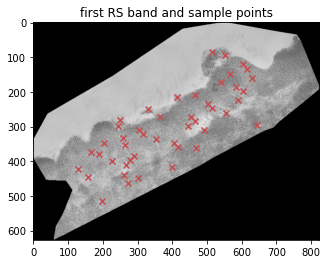

In [283]:
# Display image and Training data

plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
roi_positions = np.where(roi > 0)
plt.scatter(roi_positions[1], roi_positions[0], marker='x', c='r' )
plt.title('first RS band and sample points')


plt.show()


In [284]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

We have 46 training samples


In [285]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

In [286]:
features = pd.DataFrame(X)

band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

features['value'] = y

features.head()


The shape of our features is: (46, 25)
The number of Spectra is: 46
The number of bands is: 25


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_17,Band_18,Band_19,Band_20,Band_21,Band_22,Band_23,Band_24,Band_25,value
0,160.0,149.0,135.0,0.114000,0.120148,0.163110,0.176420,0.552506,17.835068,14.970647,...,0.088883,-0.063218,164.0,7.563913,-0.008713,66.0,55.830101,6.546875,201.489105,97.468353
1,137.0,131.0,109.0,0.083324,0.078974,0.175075,0.203454,0.612883,17.646631,30.913473,...,0.166263,-0.037736,184.0,2.541264,0.010442,81.0,53.879494,6.453125,189.203217,74.683548
2,123.0,107.0,32.0,0.078603,0.074106,0.251499,0.312596,1.777455,17.318487,27.978392,...,0.180118,-0.080808,201.0,9.483511,0.016861,87.0,52.297226,5.531250,149.371811,8.108109
3,114.0,119.0,55.0,0.088447,0.061407,0.293252,0.354843,1.610571,17.421503,22.252735,...,0.108697,0.028090,161.0,6.114932,0.040308,69.0,56.026779,6.328125,179.008682,5.263158
4,111.0,105.0,52.0,0.060741,0.047840,0.223113,0.296415,1.709244,17.412050,40.420376,...,0.071463,-0.036585,163.0,23.659445,0.018150,35.0,76.557167,5.328125,221.824509,4.375000


In [287]:
# Labels are the values we want to predict
labels = np.array(features['value'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

print('Training Features Shape: ', features.shape)
print('Training Labels Shape: ', labels.shape)

Training Features Shape:  (46, 25)
Training Labels Shape:  (46,)


Suggested number of components:  16


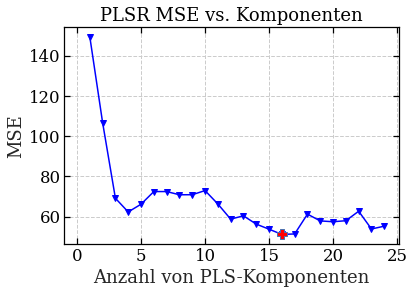

In [288]:
mse = []
component = np.arange(1, features.shape[1])

for i in component:
    pls = PLSRegression(n_components=i)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    mse.append(mean_squared_error(y, y_cv))

   # comp = 100*(i+1)/40


    # Calculate and print the position of minimum in MSE
msemin = np.argmin(mse)
suggested_comp = msemin+1
print("Suggested number of components: ", suggested_comp)
print("Suggested number of components: {}".format(suggested_comp), file=open(results_txt, "a"))

with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
    plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
    plt.xlabel('Anzahl von PLS-Komponenten')
    plt.ylabel('MSE')
    plt.title('PLSR MSE vs. Komponenten')
    plt.xlim(left=-1)
    
    plt.savefig(comp_plot,bbox_inches='tight')

plt.show()

In [289]:
# Define PLS object with optimal number of components
pls_opt = PLSRegression(n_components=msemin+1)

# Fir to the entire dataset
pls_opt.fit(X, y)
y_c = pls_opt.predict(X)

# Cross-validation
y_cv = cross_val_predict(pls_opt, X, y, cv=X.shape[0])

# Calculate scores for calibration and cross-validation
score_c = r2_score(y, y_c)
score_cv = r2_score(y, y_cv)

# Calculate mean squared error for calibration and cross validation
mse_c = mean_squared_error(y, y_c)
mse_cv = mean_squared_error(y, y_cv)


print('R2 calib: %5.3f'  % score_c)
print('R2 LOOCV: %5.3f'  % score_cv)
print('MSE calib: %5.3f' % mse_c)
print('MSE LOOCV: %5.3f' % mse_cv)

print("-----------------------", file=open(results_txt, "a"))
print('R2 calib: %5.3f'  % score_c, file=open(results_txt, "a"))
print('R2 LOOCV: %5.3f'  % score_cv, file=open(results_txt, "a"))
print('MSE calib: %5.3f' % mse_c, file=open(results_txt, "a"))
print('MSE LOOCV: %5.3f' % mse_cv, file=open(results_txt, "a"))


R2 calib: 0.979
R2 LOOCV: 0.929
MSE calib: 15.248
MSE LOOCV: 52.966


In [290]:
print("-----------------------", file=open(results_txt, "a"))
print("band importance", file=open(results_txt, "a"))

# function for variable importance
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

importance = vip(pls_opt)

imp = {}
for i in range(features.shape[1]):
    print('Band {}: {}'.format(i+1, importance[i]))
    print('Band {}: {}'.format(i+1, importance[i]), file=open(results_txt, "a"))
    imp['Band{}'.format(i+1)] = importance[i]




Band 1: 0.563551750554592
Band 2: 0.42036520583085507
Band 3: 1.2464324573753462
Band 4: 0.781239257584448
Band 5: 1.4074349692015509
Band 6: 1.214348897412875
Band 7: 1.2055141497006243
Band 8: 1.2531843525543231
Band 9: 1.1485648823414019
Band 10: 0.4541960567623845
Band 11: 0.5001786548886855
Band 12: 1.3672538791495403
Band 13: 1.193441904479328
Band 14: 1.6926471993933516
Band 15: 1.6442260208036652
Band 16: 0.43224972861675987
Band 17: 0.8451789092023813
Band 18: 0.7712638774857553
Band 19: 0.29897931890732815
Band 20: 0.9138839925866892
Band 21: 0.4547391689574163
Band 22: 0.8104910874320755
Band 23: 0.8857539693957002
Band 24: 0.5486823285770709
Band 25: 0.9245235729548587


In [291]:
print("-----------------------", file=open(results_txt, "a"))
print("sorted band importance", file=open(results_txt, "a"))
sorted_imp = dict(sorted(imp.items(), key=itemgetter(1), reverse=True))

for i in sorted_imp:
    print('{}: {}'.format(i, sorted_imp[i]))

for i in sorted_imp:
    print('{}: {}'.format(i, sorted_imp[i]), file=open(results_txt, "a"))
print("-----------------------", file=open(results_txt, "a"))

Band14: 1.6926471993933516
Band15: 1.6442260208036652
Band5: 1.4074349692015509
Band12: 1.3672538791495403
Band8: 1.2531843525543231
Band3: 1.2464324573753462
Band6: 1.214348897412875
Band7: 1.2055141497006243
Band13: 1.193441904479328
Band9: 1.1485648823414019
Band25: 0.9245235729548587
Band20: 0.9138839925866892
Band23: 0.8857539693957002
Band17: 0.8451789092023813
Band22: 0.8104910874320755
Band4: 0.781239257584448
Band18: 0.7712638774857553
Band1: 0.563551750554592
Band24: 0.5486823285770709
Band11: 0.5001786548886855
Band21: 0.4547391689574163
Band10: 0.4541960567623845
Band16: 0.43224972861675987
Band2: 0.42036520583085507
Band19: 0.29897931890732815


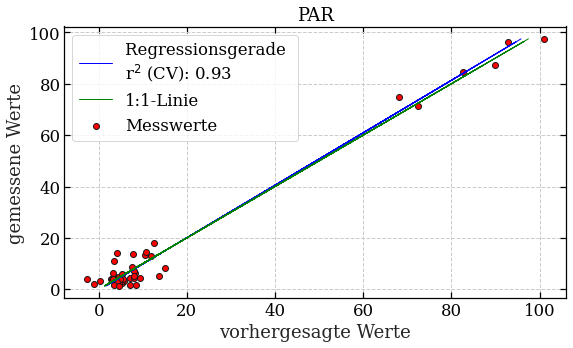

In [292]:
# Plot regression and figures of merit
rangey = max(y) - min(y)
rangex = max(y_c) - min(y_c)

# Fit a line to the CV vs response
z = np.polyfit(y, y_c, 1)
with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_c, y, c='red', edgecolors='k')
    #Plot the best fit line
    ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
    ax.plot(y, y, color='green', linewidth=1)
    plt.title(attribute)
    plt.xlabel('vorhergesagte Werte')
    plt.ylabel('gemessene Werte')
    plt.legend(['Regressionsgerade \nr$^{2}$ (CV): '+str(round(score_cv,2)),'1:1-Linie','Messwerte'])
    plt.savefig(validation_plot, bbox_inches='tight')

    plt.show()


In [293]:
# Calculate the absolute errors
errors = abs(y_cv-y)
# Print out the mean absolute error (mae)

# Print out the mean absolute error (mae)


print('-------------')
print('n of the test data: {}'.format(len(labels)))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)))
print('-------------')
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)))

print('-------------', file=open(results_txt, "a"))
print('n of the test data: {}'.format(len(labels)), file=open(results_txt, "a"))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)), file=open(results_txt, "a"))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)), file=open(results_txt, "a"))
print('-------------', file=open(results_txt, "a"))
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)), file=open(results_txt, "a"))

mse = mean_squared_error(y, y_cv)
print('Mean squared error: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(np.sqrt(mse)))
print('RPD: {:.2f} | How often does RMSE of Prediction fit in the Standard Deviation of the samples'.format(np.std(labels)/np.sqrt(mse)))

print('Mean squared error: {:.2f}'.format(mse), file=open(results_txt, "a"))
print('RMSE: {:.2f}'.format(np.sqrt(mse)), file=open(results_txt, "a"))
print('RPD: {:.2f}| How often does RMSE of Prediction fit in the Standard Deviation of the samples'.format(np.std(labels)/np.sqrt(mse)), file=open(results_txt, "a"))


'''
To put our predictions in perspective, we can calculate an accuracy using
the mean average percentage error subtracted from 100 %.
'''
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('mean absolute percentage error (MAPE): {:.2f} %'.format(np.mean(mape)))
print('accuracy (100 % - mape): {:.2f} %'.format(accuracy))


print('-------------')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(y, y_cv)))


print('mean absolute percentage error (MAPE): {:.2f} %'.format(np.mean(mape)), file=open(results_txt, "a"))
print('accuracy (100 % - mape): {:.2f} %'.format(accuracy), file=open(results_txt, "a"))


print('-------------', file=open(results_txt, "a"))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(y, y_cv)), file=open(results_txt, "a"))


-------------
n of the test data: 46
Mean of the variable: 16.20
Standard deviation of the variable: 27.27
-------------
Mean Absolute Error: 22.38
Mean squared error: 52.97
RMSE: 7.28
RPD: 3.75 | How often does RMSE of Prediction fit in the Standard Deviation of the samples
mean absolute percentage error (MAPE): 359.83 %
accuracy (100 % - mape): -259.83 %
-------------
Coefficient of determination r²: 0.93


In [294]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (627, 825, 25) to (517275, 25)


In [295]:
prediction_ = pls_opt.predict(img_as_array)

In [296]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (627, 825)


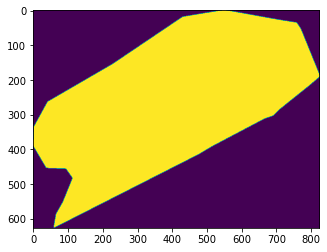

In [297]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

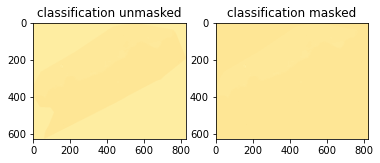

In [298]:
# mask classification an plot

prediction_ = prediction*mask

plt.subplot(121)
plt.imshow(prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

In [299]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: D:/OwnCloud/DissBeyer/tibass/bal/results/2020_08_24_BAL_PLSR_PAR.tif


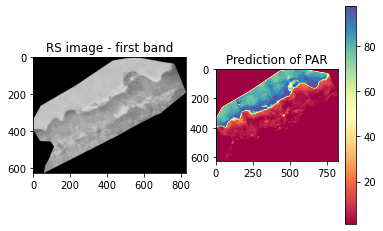

In [300]:
# Display images


plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(prediction_, cmap=plt.cm.Spectral, vmin= y.min(), vmax=y.max())
plt.title('Prediction of ' + attribute)
plt.colorbar()

plt.show()